In [1]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2
%load_ext pyinstrument

import sys
sys.path.insert(0,'..')


In [2]:
#imports 
import os
import nltk
import spacy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.onnx as onnx
import torch.optim as optim
import torchvision.models as models

from src.baseline.vocabulary import Vocabulary
from src.utils import print_time, list_of_tensors_to_numpy_arr
from src.accuracy import Accuracy
from src.baseline.coa_model import get_new_model,load_model, train_validate_test_split, init_testing_model, test_model, test_rand_image


In [3]:
!export CUDA_VISIBLE_DEVICES=0
!export CUDA_LAUNCH_BLOCKING=1

In [4]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

device

device(type='cpu')

In [5]:
# torch.cuda.get_device_name(0)

In [6]:
# Hyperparams

embed_size=300
vocab_size = 36
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4
drop_prob=0.3
ignored_idx = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

hyper_params = {'embed_size': embed_size,
                'attention_dim': attention_dim,
                'encoder_dim': encoder_dim,
                'decoder_dim': decoder_dim,
                'vocab_size': vocab_size
              }


# Test the loaded model on synthetic data

In [40]:
# data_location = '/home/space/datasets/COA/generated-data-api'
# data_location =  '/home/space/datasets/COA/generated-data-api-small'
# data_location =  '/home/space/datasets/COA/generated-data-api-large'

data_location =  '../baseline-gen-data/small'
root_folder_images = data_location + '/images'

test_caption_file = data_location + '/test_captions_psumsq.txt'
df = pd.read_csv(test_caption_file)

print("There are {} test images".format(len(df)))

There are 30 test images


In [41]:
model_path = '../models/baseline/attention_model_03.14.2022-22:14:21.pth'

model, optimizer, loss,criterion = load_model(model_path, 
                                    hyper_params, 
                                    learning_rate,
                                    drop_prob, 
                                    ignored_idx)

In [42]:
!export CUDA_LAUNCH_BLOCKING=1
!export CUDA_VISIBLE_DEVICES=2

In [47]:
# BATCH_SIZE = 5
NUM_WORKER = 2 #### this needs multi-core
freq_threshold = 5
batch_size = 256

# 30 minutes to create those, as it's baseline, i ran it several times and it's the same
vocab = Vocabulary(freq_threshold)
vocab.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'lion': 4, 'rampant': 5, 'passt': 6, 'guard': 7, 'head': 8, 'lions': 9, 'cross': 10, 'moline': 11, 'patonce': 12, 'eagle': 13, 'doubleheaded': 14, 'eagles': 15, 'a': 16, 'b': 17, 'o': 18, 's': 19, 'g': 20, 'e': 21, 'v': 22, '1': 23, '2': 24, '3': 25, '4': 26, '5': 27, '6': 28, '7': 29, '8': 30, '9': 31, '10': 32, '11': 33, 'border': 34, '&': 35}
vocab.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'lion', 5: 'rampant', 6: 'passt', 7: 'guard', 8: 'head', 9: 'lions', 10: 'cross', 11: 'moline', 12: 'patonce', 13: 'eagle', 14: 'doubleheaded', 15: 'eagles', 16: 'a', 17: 'b', 18: 'o', 19: 's', 20: 'g', 21: 'e', 22: 'v', 23: '1', 24: '2', 25: '3', 26: '4', 27: '5', 28: '6', 29: '7', 30: '8', 31: '9', 32: '10', 33: '11', 34: 'border', 35: '&'}


In [48]:
test_loader, test_dataset = init_testing_model(test_caption_file, 
                                               root_folder_images, 
                                               NUM_WORKER,
                                               vocab,
                                               batch_size, 
                                               device, 
                                               pin_memory=False)


torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])


/Users/salnabulsi/tub/coat-of-arms/notebooks/../src/baseline/caps_collate.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psum_sq = torch.tensor(psum)


torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])


/Users/salnabulsi/tub/coat-of-arms/notebooks/../src/baseline/caps_collate.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psum_sq = torch.tensor(psum)


mean, std: tensor(0.9773) tensor(0.1490)


In [50]:
test_losses, accuracy_test_list, acc_test_score, test_loss = test_model(model, 
                                                                        criterion,
                                                                        test_loader, 
                                                                        test_dataset, 
                                                                        vocab_size, 
                                                                        device)

b s s lions lions lions lions lions lions lions lions
Test Acuuracy (in progress): 0.500000

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


/Users/salnabulsi/tub/coat-of-arms/notebooks/../src/baseline/caps_collate.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psum_sq = torch.tensor(psum)


Test Loss (final): 0.103952

Test Accuracy (Overall): 50.0%


## Visualizing the attentions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


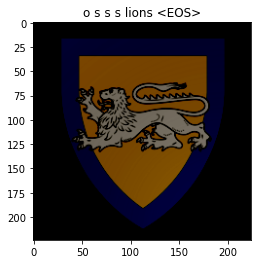

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


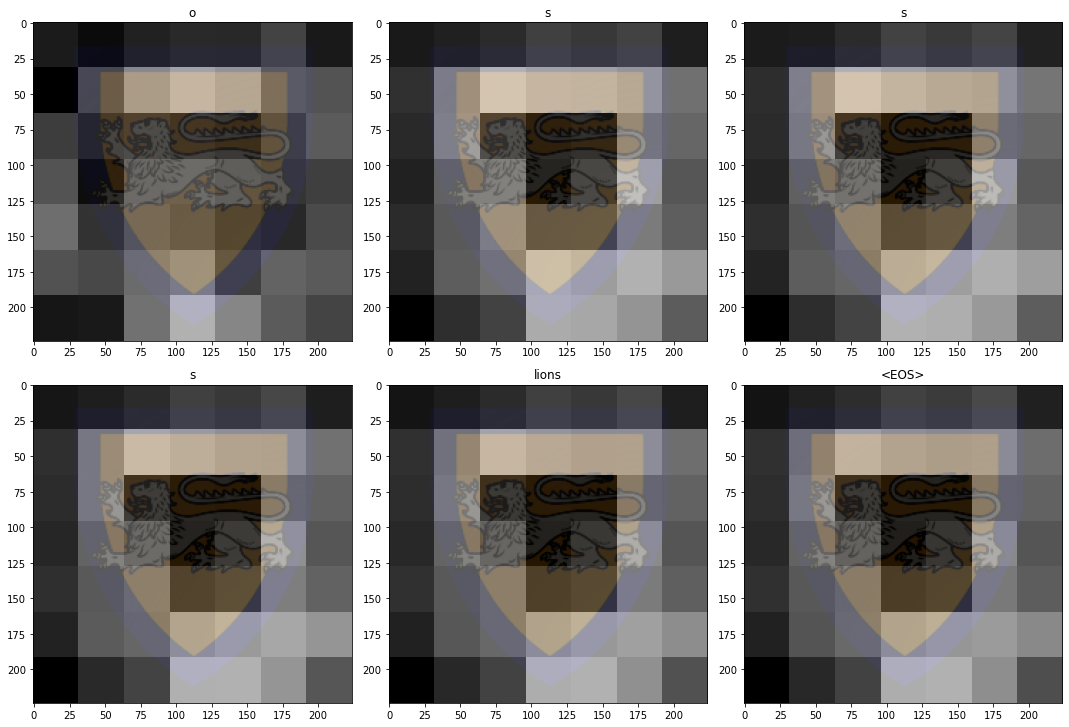

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


/Users/salnabulsi/tub/coat-of-arms/notebooks/../src/baseline/caps_collate.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psum_sq = torch.tensor(psum)


In [51]:
# torch.cuda.empty_cache()
test_rand_image(model,test_dataset,test_loader,device)

# Test the loaded model on real data


In [30]:
# data_location='/home/salnabulsi/coat-of-arms/data/cropped_coas/out_valid'
# data_location='/home/salnabulsi/coat-of-arms/data/cropped_coas/out'
# data_location='/Users/salnabulsi/tub/coat-of-arms/data/cropped_coas/out_valid'

data_location='/Users/salnabulsi/tub/coat-of-arms/data/cropped_coas/out'
test_caption_file  = data_location + '/test_real_captions_psumsq.txt'
root_folder_images = data_location + '/images'

df = pd.read_csv(test_caption_file)

print("There are {} test images".format(len(df)))

df

There are 269 test images


,image,caption,psum,psum_sq
0,1739_A G cross patonce.jpg,A G cross patonce,724933.00000,557413.50000
1,22117_O B cross patriarchal.jpg,O B cross patriarchal,696633.87500,521719.93750
2,2870_O S lion rampant.jpg,O S lion rampant,370219.71875,231043.09375
3,6870_S O eagle.jpg,S O eagle,840800.62500,661782.93750
4,18746_S A eagle.jpg,S A eagle,880971.43750,601956.43750
...,...,...,...,...
264,398_A S lion rampant.jpg,A S lion rampant,673480.62500,517651.34375
265,249_O G 2 lions passt.jpg,O G 2 lions passt,871046.06250,677358.06250
266,4459_B O eagle.jpg,B O eagle,621500.62500,425808.43750
267,5302_O B cross moline.jpg,O B cross moline,736149.62500,530970.68750


In [31]:
from PIL import Image
ls = []
for im in df['image']:
    image_full_path = root_folder_images + '/' + im
    img = Image.open(image_full_path).convert("RGB")
    ls.append(img.size)

elems, count = np.unique(ls, return_counts=True)
output = []
counter=0
for l, n in zip(elems, count):
    if n > 1:
        print(f'size: "{l}" is repeated "{n}" times')
        counter+=1

def resize(img):
    # compute width and height of image
    width, height = img.size

    # define a transform to pad an image on all sides
    transform = transforms.Pad(50)

    # apply the above transform on the image
    img = transform(img)

    # resize the image to its original dimension
    img = img.resize((width, height))
    
    return img


size: "109" is repeated "2" times
size: "112" is repeated "2" times
size: "115" is repeated "2" times
size: "116" is repeated "2" times
size: "124" is repeated "2" times
size: "304" is repeated "2" times
size: "306" is repeated "2" times
size: "317" is repeated "3" times
size: "456" is repeated "2" times
size: "466" is repeated "2" times
size: "477" is repeated "2" times
size: "486" is repeated "2" times
size: "487" is repeated "2" times
size: "564" is repeated "2" times
size: "565" is repeated "3" times
size: "566" is repeated "3" times
size: "567" is repeated "3" times
size: "569" is repeated "2" times
size: "571" is repeated "3" times
size: "573" is repeated "2" times
size: "574" is repeated "4" times
size: "575" is repeated "3" times
size: "578" is repeated "4" times
size: "580" is repeated "5" times
size: "583" is repeated "7" times
size: "584" is repeated "4" times
size: "585" is repeated "3" times
size: "586" is repeated "4" times
size: "588" is repeated "4" times
size: "589" is

In [8]:
model, optimizer, criterion = get_new_model(hyper_params, 
                                            learning_rate, 
                                            ignored_idx, 
                                            drop_prob,
                                            device)


In [9]:
!export CUDA_LAUNCH_BLOCKING=1
!export CUDA_VISIBLE_DEVICES=2


In [10]:

# BATCH_SIZE = 5
NUM_WORKER = 2 #### this needs multi-core
freq_threshold = 5
batch_size = 256

# 30 minutes to create those, as it's baseline, i ran it several times and it's the same
vocab = Vocabulary(freq_threshold)
vocab.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'lion': 4, 'rampant': 5, 'passt': 6, 'guard': 7, 'head': 8, 'lions': 9, 'cross': 10, 'moline': 11, 'patonce': 12, 'eagle': 13, 'doubleheaded': 14, 'eagles': 15, 'a': 16, 'b': 17, 'o': 18, 's': 19, 'g': 20, 'e': 21, 'v': 22, '1': 23, '2': 24, '3': 25, '4': 26, '5': 27, '6': 28, '7': 29, '8': 30, '9': 31, '10': 32, '11': 33, 'border': 34, '&': 35}
vocab.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'lion', 5: 'rampant', 6: 'passt', 7: 'guard', 8: 'head', 9: 'lions', 10: 'cross', 11: 'moline', 12: 'patonce', 13: 'eagle', 14: 'doubleheaded', 15: 'eagles', 16: 'a', 17: 'b', 18: 'o', 19: 's', 20: 'g', 21: 'e', 22: 'v', 23: '1', 24: '2', 25: '3', 26: '4', 27: '5', 28: '6', 29: '7', 30: '8', 31: '9', 32: '10', 33: '11', 34: 'border', 35: '&'}


In [11]:
test_loader, test_dataset = init_testing_model(test_caption_file, 
                                               root_folder_images, 
                                               NUM_WORKER,
                                               vocab,
                                               batch_size,
                                               device, 
                                               pin_memory=False) 
#                                                ,img_h=623, img_w=597)

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/salnabulsi/miniconda/envs/thesis-py38/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/salnabulsi/miniconda/envs/thesis-py38/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/Users/salnabulsi/tub/coat-of-arms/notebooks/../src/baseline/caps_collate.py", line 35, in __call__
    imgs    = torch.cat(imgs,dim=0)
RuntimeError: Sizes of tensors must match except in dimension 0. Got 627 and 315 in dimension 2 (The offending index is 1)


In [ ]:

test_model(model, criterion,test_loader, test_dataset, vocab_size, device)

## Visualizing the attentions


In [ ]:
# torch.cuda.empty_cache()
test_rand_image(model,test_dataset,test_loader,device)
